## Prepare grades for comments

In [1]:
import pandas as pd

In [2]:
path = '../other_dumps/comments'

In [3]:
# open the file where we'll add the final decision about comments
df_with_comments = pd.read_csv(f'{path}/VER4_all_comments_to_theories_with_scores.csv')
df_with_comments.head()

,id,status,thread,text,time,content_link,block_name,enabled,abuses,likes,replies,anon_user_id,area,step_id,topic_id,lemmatized_comments,count_bad
0,9403,fixed,comment,"""...to divide between two your friends""\r\nI t...",2019-06-08 20:14:45,https://hyperskill.org/learn/step/5614,text,0,0,0,0,45,math,5614,370.0,""" ... to divide between two your friend "" \r\n...",0
1,9408,won't fix,comment,"It was not completely clear for me, how to con...",2019-06-08 20:32:26,https://hyperskill.org/learn/step/5614,text,1,0,3,2,45,math,5614,370.0,"it be not completely clear for I , how to conv...",1
2,15054,fixed,feedback,completly not understood,2019-07-09 11:11:43,https://hyperskill.org/learn/step/5753,text,1,0,0,0,105,math,5753,385.0,completly not understand,1
3,15115,fixed,feedback,A better explanation is needed with clear defi...,2019-07-09 17:34:21,https://hyperskill.org/learn/step/5753,text,1,0,0,0,109,math,5753,385.0,a well explanation be need with clear definiti...,2
4,15268,fixed,comment,>remember that 2^8 in decimal is 1000 0000 in ...,2019-07-10 16:03:41,https://hyperskill.org/learn/step/5753,text,0,0,1,0,122,math,5753,385.0,> remember that 2 ^ 8 in decimal be 1000 0000 ...,0


In [4]:
print(df_with_comments.shape[0])
print(df_with_comments[df_with_comments.count_bad > 0].shape[0])

23905
8419


In [5]:
df_with_polarities = pd.read_csv(f'{path}/all_comments_to_theories_with_3_polarities.csv')

In [6]:
# add polarities to the file with counts of bad words
df_with_comments['TextBlobPolarity'] = df_with_polarities.TextBlobPolarity
df_with_comments['FlairPolarity'] = df_with_polarities.FlairPolarity
df_with_comments['VaderPolarity'] = df_with_polarities.VaderPolarity
df_with_comments.head()

,id,status,thread,text,time,content_link,block_name,enabled,abuses,likes,replies,anon_user_id,area,step_id,topic_id,lemmatized_comments,count_bad,TextBlobPolarity,FlairPolarity,VaderPolarity
0,9403,fixed,comment,"""...to divide between two your friends""\r\nI t...",2019-06-08 20:14:45,https://hyperskill.org/learn/step/5614,text,0,0,0,0,45,math,5614,370.0,""" ... to divide between two your friend "" \r\n...",0,0.000000,0.817580,0.7351
1,9408,won't fix,comment,"It was not completely clear for me, how to con...",2019-06-08 20:32:26,https://hyperskill.org/learn/step/5614,text,1,0,3,2,45,math,5614,370.0,"it be not completely clear for I , how to conv...",1,0.065278,-0.999997,0.6766
2,15054,fixed,feedback,completly not understood,2019-07-09 11:11:43,https://hyperskill.org/learn/step/5753,text,1,0,0,0,105,math,5753,385.0,completly not understand,1,0.000000,-0.999818,0.0000
3,15115,fixed,feedback,A better explanation is needed with clear defi...,2019-07-09 17:34:21,https://hyperskill.org/learn/step/5753,text,1,0,0,0,109,math,5753,385.0,a well explanation be need with clear definiti...,2,0.300000,0.765204,0.6705
4,15268,fixed,comment,>remember that 2^8 in decimal is 1000 0000 in ...,2019-07-10 16:03:41,https://hyperskill.org/learn/step/5753,text,0,0,1,0,122,math,5753,385.0,> remember that 2 ^ 8 in decimal be 1000 0000 ...,0,0.000000,-0.999927,0.0258


In [7]:
def get_neg_score_from_three(blob, flair, vader, blob_thrshld=0.5, flair_thrshld=0.75, vader_thrshld=0.5):
    """
    Comment has >= 2 negative scores --> negative.
    Otherwise -- neutral.
    """
    list_less_thrshld = [el <= -thrshld for el, thrshld in zip([blob, flair, vader], 
                                                               [blob_thrshld, flair_thrshld, vader_thrshld])]
    if sum(list_less_thrshld) >= 2:
        return -1
    else:
        return 0

<AxesSubplot:>

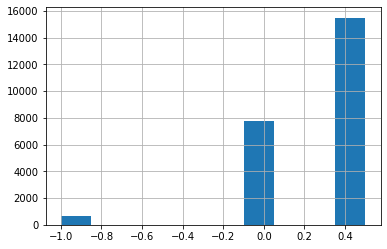

In [8]:
grades = []

for i, row in df_with_comments.iterrows():
    if row.count_bad == 0:  # if there are no suspicious words in the comment, we mark it separately
        grades.append(0.5)
        continue
    
    blob = row.TextBlobPolarity
    flair = row.FlairPolarity
    vader = row.VaderPolarity
    
    common_decision = get_neg_score_from_three(blob, flair, vader)
    grades.append(common_decision)
    
df_with_comments['comment_grades'] = grades
df_with_comments.comment_grades.hist()

In [9]:
print(df_with_comments[df_with_comments.comment_grades == -1].shape[0])  # 'bad' comments
print(df_with_comments[df_with_comments.comment_grades == 0.5].shape[0])  # comments without trigger words
print(df_with_comments[df_with_comments.comment_grades == 0].shape[0])  # all other comments

660
15486
7759


In [10]:
df_with_comments.to_csv(f'{path}/VER4_all_comments_to_theories_with_scores.csv', index=False)

## Split topics according to comments' grades

In [11]:
def count_good_and_bad_comments_per_each_topic(df):
    """
    We need to store IDs of comments, to be able to check the number of their reactions later.
    """
    bad_comments_count_for_topics = dict()
    good_comments_count_for_topics = dict()

    for i, row in df.iterrows():
        status = row['status']
        comment_grade = row['comment_grades']
        topic_id = row['topic_id']

        # add the bad comments count
        if topic_id in bad_comments_count_for_topics:
            if comment_grade == -1 and status != 'fixed':
                bad_comments_count_for_topics[topic_id].append(row.id)
            else:
                pass  # topic is in the dict but this comment is not bad so we don't add it

        else:
            if comment_grade == -1 and status != 'fixed':
                bad_comments_count_for_topics[topic_id] = [row.id]  # this is the first comment for topic and it's bad
            else:
                bad_comments_count_for_topics[topic_id] = []  # this is the first comment for topic and it's not bad

        # now add the good comments count
        if topic_id in good_comments_count_for_topics:
            if comment_grade == 1:
                good_comments_count_for_topics[topic_id].append(row.id)
            else:
                pass 
        else:
            if comment_grade == 1:
                good_comments_count_for_topics[topic_id] = [row.id]  
            else:
                good_comments_count_for_topics[topic_id] = []
                
    return bad_comments_count_for_topics, good_comments_count_for_topics

In [12]:
bad_comments_count_for_topics, good_comments_count_for_topics = count_good_and_bad_comments_per_each_topic(df_with_comments)

In [13]:
bad_comments_count_for_topics[362]

[193128, 1579354]

In [14]:
def divide_into_bad_and_rest(bad_comments_count_for_topics, threshold):
    """
    For each topic, if it has >=threshold bad comments -- it's bad. Otherwise it's 'the rest'.
    """
    final_bad_topics = []
    final_rest_topics = []

    for topic_id in bad_comments_count_for_topics:
        bad_num = len(bad_comments_count_for_topics[topic_id])

        if bad_num >= threshold:
            final_bad_topics.append(topic_id)
        else:
            final_rest_topics.append(topic_id)
            
    return final_bad_topics, final_rest_topics

In [15]:
final_bad_topics_2, final_rest_topics_2 = divide_into_bad_and_rest(bad_comments_count_for_topics, threshold=2)

In [16]:
print('good dataset', len(final_rest_topics_2))
print('bad dataset', len(final_bad_topics_2))

good dataset 978
bad dataset 142


## Check the division of the topics with high likes and extend the corpus

In [17]:
import pickle

In [18]:
step_id_topic_id_mapping = pickle.load(open('step_id_topic_id_mapping.pkl', 'br'))

In [19]:
file = '../topics_with_statistics/topics_3_months_with_statistics_and_scores.csv'
topic_statistics = pd.read_csv(file)

In [20]:
# df with topcis where we can trust likes (with >20 evaluations)
more_likes = topic_statistics[topic_statistics.last_3_month_likes_count > 20]
very_good_topics = more_likes[more_likes.last_3_month_avg_like > 1.85]
good_like_steps = [row['step_id'] for i, row in very_good_topics.iterrows()]
good_like_topics = set([step_id_topic_id_mapping[step_id] for step_id in good_like_steps])

In [21]:
intersected_good_like_bad_comments_2 = good_like_topics.intersection(final_bad_topics_2)
print(len(intersected_good_like_bad_comments_2)) 

11


In [22]:
for el in intersected_good_like_bad_comments_2:
    print(el)

673.0
227.0
166.0
6.0
585.0
429.0
685.0
529.0
530.0
121.0
634.0


We have already checked it, in VER3: they could really use some improvement!

* 673 -- bad from the previous case
* 227 -- could use some improvement
* 166 -- too!
* 6  -- too
* 585 -- bad from the previous case
* 429 -- bad from the previous case
* 685 -- it's OK
* 529 -- may need improvement
* 530 -- may need improvement
* 121 -- bad from the previous case
* 634 -- may need improvement

In [25]:
# what about 685? Why is it still classified as bad?
comments_for_this_topic = df_with_comments[df_with_comments.topic_id == 685]
for com in comments_for_this_topic.text.values:
    if len(com) < 10000:
        print(com)
        print('<-------------->')

Very nice tool for better efficiency! Avoids some redundant for loops to extract values, a simple asterisk would suffice :)
<-------------->
Importance of 'the order of passed arguments' had to be mentioned.
<-------------->
Cần giải thích kỹ hơn phần kết hợp
- print(*(something)) với hàm def add(*arg)
<-------------->
I wish you showed unpacking operator for the first stage as well.
<-------------->
some context needed for keyword only parameters topic
<-------------->
Can someone help me with keyword only ?
I can't recall if it is covered in earlier topics or not!
help needed here
<-------------->
Hey Mods!! aren't default values automatically keyword arguments?
From the theory:

Normally, *args comes after specific parameters:

def func(positional_args, defaults, *args):
    pass

Once all required arguments have been passed, the remaining values are packed into the tuple.

The parameters that come after *args are keyword-only. It means that they can only be used as keywords rather 

Apparently there's a recipe in the topic and users disucc it. But otherwise the topic is fine!

In [24]:
df_with_features = pd.DataFrame({'topic_id': list([int(el) for el in final_bad_topics_2]) +\
                                 list([int(el) for el in final_rest_topics_2]), 
                                'target': [1] * len(final_bad_topics_2) + [0] * len(final_rest_topics_2)})

In [26]:
path = './new_cleaned/train_corpus/target_features'
df_with_features.to_csv(f'{path}/topic_ids_with_target_features_VER4.csv', index=False)